In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)


Python version
3.10.1 | packaged by conda-forge | (main, Dec 22 2021, 01:39:05) [GCC 9.4.0]
Version info.
sys.version_info(major=3, minor=10, micro=1, releaselevel='final', serial=0)


In [1]:
import numpy as np
import cfgrib
import xarray as xr
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import time
from pstats import SortKey
import dask

In [2]:
pc_r_d = 287.05
pc_r_v = 461.51  # Gas constant for water vapour[J kg-1 K-1]
pc_cp_d = 1005.0
pc_rvd = pc_r_v / pc_r_d

pc_rdocp = pc_r_d/pc_cp_d
pc_rvd_o = pc_rvd - 1.0

# Reference surface pressure for computation of potential temperature
p0 = 1.0e5

In [57]:
del cluster
#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster(queue='postproc', cores=2, memory='24GB')

In [58]:
cluster

NameError: name 'cluster' is not defined

In [3]:
scheduler='synchronous'
if scheduler=='distributed':
    from dask.distributed import Client
    client = Client(cluster)
    client
elif scheduler=='threads':
    dask.config.set(scheduler='threads')
elif scheduler=='synchronous':
    dask.config.set(scheduler='synchronous')  # overwrite default with single-threaded scheduler
elif scheduler=='mpi':
    from dask.distributed import Client
    client = Client(scheduler_file='/users/cosuna/dask-scheduler.json', dashboard_address="localhost:9955")
    

In [3]:
client.dashboard_link

NameError: name 'client' is not defined

In [4]:

pr = cProfile.Profile()
pr.enable()

pc_g = 9.80665

def destagger(u, du):
    du[1:-1, :] += u[2:, :] + u[0:-2, :]


def level_range(index, short_name):
    levels = index.subindex(
        filter_by_keys={'shortName': short_name, 'typeOfLevel': 'generalVerticalLayer'}).header_values['level:float']

    return (min(levels), max(levels))


def fthetav(p, t, qv):
    return (p0 / p) ** pc_rdocp * t * (1.+(pc_rvd_o*qv / (1.-qv)))

def fbrn(p,t,qv,u,v,hhl,hsurf):
    thetav = fthetav(p,t,qv)
    # thetav.data.visualize(filename='thetav.svg')

    thetav_sum = thetav.isel(generalVerticalLayer=slice(None, None, -1)).cumsum(dim='generalVerticalLayer') 

    # dask.delayed(thetav_sum.data).visualize(filename='thetasum.svg')

    nlevels_xr =xr.DataArray(data=np.arange(nlevels,0,-1), dims=["generalVerticalLayer"])

    brn = pc_g* (hhl-hsurf)*(thetav - thetav.isel(generalVerticalLayer=79)) / \
        ( (thetav_sum/nlevels_xr)*(u**2 + v**2))
    return brn


In [6]:
data_dir ='/scratch/cosuna/postproc_np_products/grib_files/cosmo-1e/'

start = time.time()
index = cfgrib.open_fileindex(
        data_dir+'/lfff00000000', index_keys=cfgrib.dataset.INDEX_KEYS + ["time", "step"]+["shortName", "paramId"])
levels = level_range(index, 'T')



In [7]:
def load_data(chunk_size=10):
    
    chunk_arg={}
    if chunk_size:
        chunk_arg = {'chunks':{"generalVerticalLayer":chunk_size}}

    param_dict = {"PS": 500000, "U": 500028, "V": 500030, "P": 500001, "T": 500014, "QV": 500035, "U_10M": 500027, "V_10M": 500029, 
                  "T_2M": 500011, "QV_2M": 500034, "T_G": 500010, "QC": 500100, "QI": 500101, "QR": 500102, "QS": 500103, 
                 "QG": 500106, "CLC": 500098, "CLC_CON": 500047, "CLW_CON": 500117, "W_SNOW": 500044}   

    dataset = {key: cfgrib.open_dataset(data_dir+'/lfff00000000',
                                   backend_kwargs={'read_keys': ['paramId'], 'filter_by_keys': {
                                       'paramId': paramId}}, encode_cf=("time", "geography", "vertical"), 
                                        **chunk_arg)[key] for key, paramId in param_dict.items()}

    dataset["HSURF"] = cfgrib.open_dataset(data_dir+'/lfff00000000c',
                                        backend_kwargs={'read_keys': ['paramId'], 
                                        'filter_by_keys': {'paramId': 500007}},
                                        encode_cf=("time", "geography", "vertical"), 
                                        **chunk_arg
                               )["HSURF"]

    hhl = cfgrib.open_dataset(data_dir+'/lfff00000000c',
                                  backend_kwargs={'read_keys': ['paramId'],
                                                  'filter_by_keys': {'paramId': 500008}}, 
                              encode_cf=("time", "geography", "vertical"), 
                              **chunk_arg)["HHL"]
    dataset["HHL"] = hhl.rename({'generalVertical':'generalVerticalLayer'})
    
    dataset['SOILTYP'] = cfgrib.open_dataset(data_dir+'/lfff00000000c',
                                  backend_kwargs={'read_keys': ['paramId'],
                                                  'filter_by_keys': {'paramId': 500205}}, 
                              encode_cf=("time", "geography", "vertical"), 
                              **chunk_arg)["SOILTYP"]

    return dataset

In [8]:
def havg(f):
    start=time.time()
    x = f.copy(deep=True)
    x[dict(x = slice(1,-1), y=slice(1,-1))] = f[dict(x = slice(0,-2), y = slice(1,-1))] + \
            f[dict(x = slice(2,None), y = slice(1,-1))] + f[dict(x = slice(1,-1), y = slice(0,-2))] + \
            f[dict(x = slice(1,-1), y = slice(2,None))]
    end=time.time()
    print("KKK", end-start)
    return x

In [9]:
def upscale(f, xbounds, ybounds, step=3):
    start=time.time()
    step=3
    x = f[dict(x = slice(xbounds[0]-1,xbounds[1]-1,step), y = slice(ybounds[0],ybounds[1],step))] + \
            f[dict(x = slice(xbounds[0]+1,xbounds[1]+1,step), y = slice(ybounds[0],ybounds[1],step))] + \
            f[dict(x = slice(xbounds[0],xbounds[1],step), y = slice(ybounds[0]-1,ybounds[1]-1,step))] + \
            f[dict(x = slice(xbounds[0],xbounds[1],step), y = slice(ybounds[0]+1,ybounds[1]+1,step))]
    end=time.time()
    print("LLL", end-start)
    return x

In [10]:
def intpl_k2khalf(f):
    return 0.5*(f[dict(generalVerticalLayer = slice(0,-1))] + f[dict(generalVerticalLayer = slice(1,None))])

In [11]:
nlevels = int(levels[1]) - int(levels[0])+1
dataset = load_data(chunk_size=10)

Frozen({'y': 786, 'x': 1170})
LLL 0.09051203727722168
LLL 0.08226561546325684
LLL 0.08361053466796875
LLL 0.07909917831420898
LLL 0.07816696166992188
LLL 0.07878971099853516
LLL 0.07863473892211914
LLL 0.0789041519165039
LLL 0.07868456840515137
LLL 0.07746052742004395
LLL 0.0781092643737793
LLL 0.08461260795593262
LLL 0.08410334587097168
LLL 0.07981443405151367
LLL 0.07849955558776855
LLL 0.07894039154052734
LLL 0.0799872875213623
LLL 0.0789022445678711
LLL 0.07721972465515137
<xarray.DataArray 'P' (generalVerticalLayer: 78, y: 258, x: 386)>
dask.array<mul, shape=(78, 258, 386), dtype=float32, chunksize=(10, 258, 386), chunktype=numpy.ndarray>
Coordinates:
  * generalVerticalLayer  (generalVerticalLayer) float64 2.0 3.0 ... 78.0 79.0
    number                int64 0
    time                  datetime64[ns] 2021-11-02T12:00:00
    step                  timedelta64[ns] 00:00:00
    valid_time            datetime64[ns] 2021-11-02T12:00:00
Dimensions without coordinates: y, x
<xarray.Data

(array([      0.,       0.,       0.,       0.,       0., 7967040.,
              0.,       0.,       0.,       0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

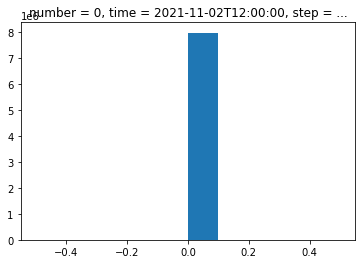

In [12]:
print(dataset['HSURF'].sizes)
xbounds = (1, 1158)
ybounds = (1, 774)

soiltyp = dataset['SOILTYP']
hsurf,t,p,qv,ps,u_10m,v_10m,t_2m,qv_2m,t_g,qc,qi,qr,qs,qg,clc,clc_con,clw_con,w_snow = \
    [upscale(dataset[name], xbounds, ybounds, step=3) for name in ['HSURF','T','P','QV','PS',\
                            'U_10M','V_10M','T_2M','QV_2M','T_G','QC','QI','QR','QS','QG',\
                            'CLC','CLC_CON','CLW_CON','W_SNOW']]

den = p / ( pc_r_d * t * (1.0 + pc_rvd_o*qv - qc - qi - qr - qs - qg) )

t,p,qv = [intpl_k2khalf(f) for f in [t,p,qv]]


qsg = qs+qg
qisg = qs+qg+qi
rttov_stype = xr.where(soiltyp<9,0, soiltyp)
rttov_stype = xr.where(rttov_stype==9, 1, rttov_stype)
rttov_stype = xr.where(rttov_stype==10, 2, rttov_stype)

rttov_wtype = xr.where(soiltyp<9,0, soiltyp)
rttov_wtype = xr.where(rttov_wtype==9, 0, rttov_wtype)
rttov_wtype = xr.where(rttov_wtype==10, 0, rttov_wtype)

rttov_frsnow = xr.where(w_snow > 1.0, 1.0, w_snow)*66.7
rttov_frcloud = xr.where(qsg>1e-7,1,clc)*0.01

cloud6_without_qi = qsg*den*1000
cloud6_with_qi = qisg*den*1000

print(p)
print(rttov_frcloud)
print(qc,den) 
cloud1 = xr.where(rttov_frcloud==0, 0, qc*den*1000)
cloud3 = xr.where((rttov_frcloud==0) | (clc_con == 0), 0, clw_con*den*1000)
rttov_cloud_6 = xr.where(rttov_frcloud==0,0,cloud6_with_qi)
rttov_cloud_6 = xr.where((rttov_frcloud>0) & (qi <= 1e-7),cloud6_without_qi,rttov_cloud_6)

cloud3.plot()


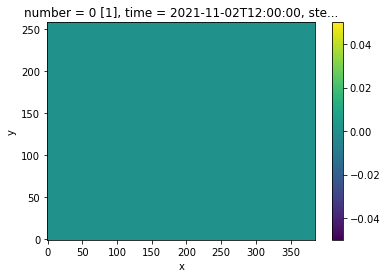

In [168]:
cloud1[dict(generalVerticalLayer=4)].plot()



In [53]:
start=time.time()
brn = fbrn(p,t,qv,u,v,hhl,hsurf)
brn.name = "BRN"
end=time.time()
print("Time:", end-start)

Time: 4.6542909145355225


In [55]:
start=time.time()
#brn.compute()
brn.compute()
#brn.isel(generalVerticalLayer=slice(37,80,1)).to_netcdf(path="brn_out.nc")
end=time.time()
print("Time:", end-start)

Time: 4.820379257202148


In [9]:
brn

<xarray.DataArray 'BRN' (generalVerticalLayer: 80, y: 786, x: 1170)>
array([[[ 5.62498568e+00,  5.58283520e+00,  5.56662824e+00, ...,
          8.08694283e+00,  8.05338499e+00,  8.01998957e+00],
        [ 5.65390283e+00,  5.59547880e+00,  5.58109462e+00, ...,
          8.11574342e+00,  8.08141939e+00,  8.04753769e+00],
        [ 5.70246864e+00,  5.61844281e+00,  5.59849780e+00, ...,
          8.15699927e+00,  8.12314932e+00,  8.09084559e+00],
        ...,
        [ 2.04341788e+02,  2.08336806e+02,  2.12171970e+02, ...,
          1.61346427e+01,  1.61654894e+01,  1.62214131e+01],
        [ 1.97226524e+02,  2.01183487e+02,  2.05061044e+02, ...,
          1.61012215e+01,  1.61220736e+01,  1.61798920e+01],
        [ 1.90594335e+02,  1.94562431e+02,  1.98309917e+02, ...,
          1.60731945e+01,  1.60914955e+01,  1.61438843e+01]],

       [[ 1.87543201e+01,  1.84160456e+01,  1.81456440e+01, ...,
          1.83493222e+01,  1.83769085e+01,  1.84041787e+01],
        [ 1.88344896e+01,  1.84492765e+01,  1.82005241e+01, ...,
          1.83501450e+01,  1.83739904e+01,  1.83964875e+01],
        [ 1.88053070e+01,  1.83741351e+01,  1.81270037e+01, ...,
          1.83837568e+01,  1.84066499e+01,  1.84292034e+01],
...
        [-1.77857848e-01, -1.77045065e-01, -1.79599251e-01, ...,
         -3.29189875e-01, -3.24802477e-01, -3.21378116e-01],
        [-1.76326219e-01, -1.77463675e-01, -1.79812988e-01, ...,
         -3.39025383e-01, -3.31536802e-01, -3.25461321e-01],
        [-1.76762169e-01, -1.77827134e-01, -1.80206656e-01, ...,
         -3.43849103e-01, -3.37004056e-01, -3.31169704e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * generalVerticalLayer  (generalVerticalLayer) float64 1.0 2.0 ... 79.0 80.0
    number                int64 0
    time                  datetime64[ns] 2021-11-02T12:00:00
    step                  timedelta64[ns] 00:00:00
    latitude              (y, x) float64 42.14 42.14 42.14 ... 50.16 50.16 50.16
    longitude             (y, x) float64 0.7593 0.7726 0.786 ... 17.52 17.54
    valid_time            datetime64[ns] 2021-11-02T12:00:00
    surface               float64 ...
Dimensions without coordinates: y, x